# Create supersites_geom.geojson geojson file with the caucus supersite borders

#### latest run of notebook: 1/14/2024 7am

## Main Steps
1. create supersites DataFrame from Judi's supersite precinct file
    - INPUT: data/2024_Supersite_list w Chairs & Cochairs.xlsx (update: 1/13/2024)
    - OUTPUT: none
2. create pctgeo (precinct GeoDataFrame)
    - INPUT: read precinct geometry from current pct_area_boulder.geojson file
    - add supersite name column using supersites dataframe
    - OUTPUT: data/pct_supersite.geojson (save pctgeo with supersite column) 
3. create supersite border geometry and save geojson file
    - create ssgeo from pctgeo by using dissolve('supersite')
    - OUTPUT: data/supersites_region_geom.geojson (save ssgeo)
4. add supersite location information and save file
    - from supersite_venues_all_years.xlsx
        - address
        - website
        - google map link
        - location geometry
    - save to supersite_venues.xlsx worksheet=2024
    - save to supersite_venues_2024.geojson

- NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

### Notebook History Summary
- full history see git commits
- Started: January 7, 2024
- Update: January 8, 2024 - large revision - add ssname column to supersites
- Update: January 9, 2024 - version 0.1.0 add ssgeom to supersitesgeo
- Update: January 11, 2024 - version 0.2.0 add pctlist column to supersites dataframe
- Update: January 12, 2024 - version 0.3.0 start supersite boundary geometry
- Update: January 13, 2024 - version 0.3.1 finish supersite boundary geometry
- Update: January 19, 2024 - version 0.4.0 add supersite locations

### Variables

- supersites    - DataFrame read from Judi's supersite file
- pctgeo        - GeoDataFrame read from pct_area_boulder.geojson
- sss_pcts_lists    - list of lists of all the precincts at a supersite
- ssgeo         - GeoDataFrame of supersites with region boundaries


##     ISSUES

#### FIXED Precinct format mismatch
- pct_area_boulder.geojson lists zero-filled precincts, e.g. 002, 003, 004
- Draft Supersites-judi-20240106.xlsx lists single-digit precincts, e.g. 2, 3, 4
    - notebook creates rows for both, 002 and 2, 003 and 3, 004 and 4
    - not critical failure but should be fixed. 
- WORKAROUND: drop extra rows 2, 3, 4
- FIXED: zfill precincts when reading in Judi's file


In [1]:
import pandas as pd
import geopandas as gpd

import supersites as ss
# import fiona
# import numpy as np

## 1. Create supersites - dataframe of supersites with list of precincts in a column  
- start with Judi's spreadsheet
- create pctlist from "Pct #'s" column
    - use pctstr_to_list(ss) function to create series of lists
    - add pctlist series as column on supersites

In [2]:
# check supersites
# - total_precincts matches length of pctlist for each supersites
# - 20 unique supersites in dataframe
# - all columns are 20 non-null


supersite_input = 'data/2024_Supersite_list w Chairs & Cochairs.xlsx' # 1/13/2024
sheetname ='Recap SS & Precinct #s'

supersites = ss.read_supersite_pct(supersite_input, sheetname)
supersites.info()
supersites

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   supersite          20 non-null     object
 1   dems               20 non-null     int64 
 2   attendee_forecast  20 non-null     int64 
 3   total_precincts    20 non-null     int64 
 4   pctlist            20 non-null     object
dtypes: int64(3), object(2)
memory usage: 928.0+ bytes


,supersite,dems,attendee_forecast,total_precincts,pctlist
0,Allenspark Fire Station,155,4,1,[914]
1,Altona MS,7518,188,14,"[605, 606, 607, 608, 609, 610, 611, 614, 615, ..."
2,Boulder HS,7241,181,10,"[810, 817, 818, 820, 821, 828, 829, 831, 832, ..."
3,Burlington Elementary,3351,84,7,"[600, 601, 602, 603, 604, 612, 613]"
4,Casey MS,4696,117,7,"[822, 823, 824, 825, 826, 827, 910]"
5,Centaurus HS,11327,283,20,"[300, 301, 302, 303, 304, 305, 306, 307, 308, ..."
6,Centennial MS,8884,222,13,"[803, 804, 805, 806, 807, 811, 812, 813, 814, ..."
7,Eldorado K8,3303,83,8,"[003, 100, 101, 102, 103, 104, 105, 106]"
8,Erie MS,3936,98,9,"[400, 401, 402, 403, 404, 405, 406, 407, 408]"
9,Gold Hill School,308,8,1,[909]


In [3]:
# pct_ss['pctlist'].nunique()

In [4]:
# pct_ss[pct_ss.duplicated(subset=['pctlist'])]
# pct_ss[pct_ss.duplicated()]

In [5]:
# pct_ss[pct_ss['pctlist']=='631']

In [6]:
# altona_pcts = supersites[supersites['supersite']=='Altona MS']['pctlist'].to_list()
# altona_pcts

## 2 create pctgeo (precinct GeoDataFrame)
- read precinct geometry from current pct_area_boulder.geojson file
- add supersite name column using supersites dataframe
- save as pct_supersite.geojson

In [7]:
# 2. Create pctgeo, GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set pctgeo index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 16.1+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


In [8]:
# FUNCTION: Add supersite name column to pctgeo

def add_ss_to_pctgeo(ssdf):

    for ss in ssdf.index:

        # get pctlist in first supersite
        pctlist = ssdf['pctlist'][ss]
        # print(pctlist, '\n')  # list of pcts in supersite

        # get supersite name
        ssname = ssdf.loc[ss,'supersite'] 

        # loop through each pct in pctlist

        for p in pctlist:
            
            # print(p, ssname,'\n')

            # add supersite name to pctgeo
            pctgeo.loc[p, 'supersite'] = ssname
            # print(pctgeo.loc[p, :], '\n')  #  dataframe row
    return



In [9]:
# add supersite column to pctgeo and populate it
pctgeo['supersite'] = ''
add_ss_to_pctgeo(supersites)

pctgeo.info() # check all columns have 193 non-null values
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1...",Trail Ridge MS
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9...",Eldorado K8
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9...",Manhattan MS
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9...",Eldorado K8
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9...",Eldorado K8


In [10]:
# ### Check precinct data in  geodataframe
# - Number of precincts = 193
# - Number of Areas = 27
# - Check precincts in each Area

pctgeo['Pct'].nunique() # 193
# pctgeo.AreaShort.nunique() # 27
# pctgeo.value_counts('AreaShort').sort_index()

193

In [11]:
# check # of supersites - expect 20
pctgeo['supersite'].nunique()

# check precincts per supersite
pctgeo['supersite'].value_counts()

supersite
Centaurus HS                20
Longs Peak MS               18
Trail Ridge MS              17
Southern Hills MS           15
Niwot HS                    14
Altona MS                   14
Manhattan MS                13
Monarch HS                  13
Centennial MS               13
Boulder HS                  10
Erie MS                      9
Eldorado K8                  8
Burlington Elementary        7
Casey MS                     7
Nederland HS                 6
Lyons Middle Senior          5
Ward Private Home            1
Gold Hill School             1
Jamestown School             1
Allenspark Fire Station      1
Name: count, dtype: int64

In [12]:
# save pctgeo with supersite column to file 
pctgeo.to_file('data/pct_supersite.geojson', driver='GeoJSON', index=False)

### 3 Create Supersite GeoDataFrame, ssgeo, and add geometry column 

- create ssgeo by dissolving pctgeo('supersite')
- save ssgeo to supersites_region_geom.geojson

,supersite,geometry
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2..."
1,Altona MS,"POLYGON ((-105.14621 40.12873, -105.14638 40.1..."
2,Boulder HS,"POLYGON ((-105.26650 40.00008, -105.26776 40.0..."
3,Burlington Elementary,"POLYGON ((-105.12952 40.13073, -105.12974 40.1..."
4,Casey MS,"POLYGON ((-105.25838 40.01917, -105.25838 40.0..."
5,Centaurus HS,"MULTIPOLYGON (((-105.05283 39.97775, -105.0624..."
6,Centennial MS,"POLYGON ((-105.27269 40.03465, -105.27268 40.0..."
7,Eldorado K8,"POLYGON ((-105.14702 39.92762, -105.14702 39.9..."
8,Erie MS,"POLYGON ((-105.05531 40.02197, -105.05532 40.0..."
9,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0..."


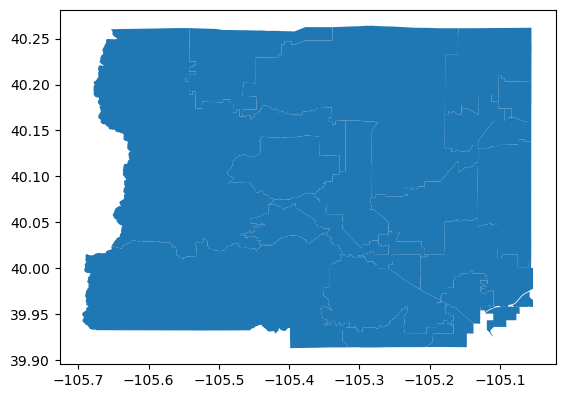

In [13]:
# Create ssgeo: Supersite GeoDataFrame with supersite boundaries
#   pctgeo.dissolve('supersite') 
#      group precincts by supersite 
#      combine group precinct geometry into supersite geometry

ssgeo = pctgeo.dissolve('supersite')
ssgeo = ssgeo.reset_index()
ssgeo = ssgeo[['supersite','geometry']]
ssgeo['supersite'] = ssgeo['supersite'].str.strip()

ssgeo.to_file('data/supersites_region_geom.geojson', driver='GeoJSON')

ssgeo.plot()
ssgeo

### test supersite_region_geom.geojson

In [14]:
supersite_test = gpd.read_file('data/supersites_region_geom.geojson', driver='GeoJSON')
supersite_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  20 non-null     object  
 1   geometry   20 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 448.0+ bytes


<Axes: >

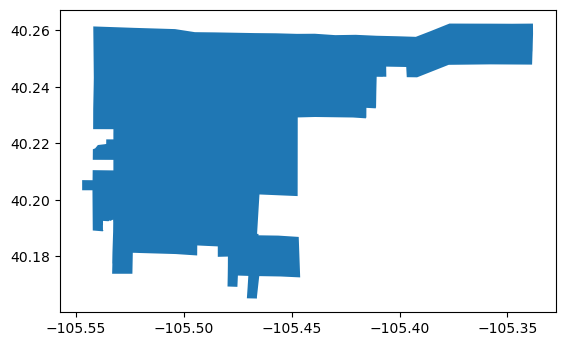

In [15]:
# supersite_test[supersite_test['supersite'] == 'Boulder HS'].plot()
supersite_test[supersite_test['supersite'] == 'Allenspark Fire Station'].plot()

## 4 ADD LOCATION COLUMN TO 2024 SUPERSITES
- ssgeo GeoDataFrame
    - add location_geom column from supersite_venues_all_years.xlsx
    - copy geometry column to border
    - set_geometry('border') to border

In [16]:
ssgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  20 non-null     object  
 1   geometry   20 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 448.0+ bytes


In [17]:
ssgeo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# read in supersite_venues.xlsx
venues = pd.read_excel('data/supersite_venues_all_years.xlsx')

venues.info()
venues.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Venue             29 non-null     object 
 1   address           28 non-null     object 
 2   organization      25 non-null     object 
 3   website           27 non-null     object 
 4   google_map_link   28 non-null     object 
 5   google_map_name   29 non-null     object 
 6   geometry-invalid  29 non-null     object 
 7   lat               29 non-null     float64
 8   lon               29 non-null     float64
 9   google_map_url    28 non-null     object 
 10  website_url       27 non-null     object 
dtypes: float64(2), object(9)
memory usage: 2.6+ KB


,Venue,address,organization,website,google_map_link,google_map_name,geometry-invalid,lat,lon,google_map_url,website_url
0,Allenspark Fire Station,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,POINT (-105.5279141785934 40.19712777610975),40.197128,-105.527914,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,http://www.allensparkfire.com/
1,Altona MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,POINT (-105.1626179175455 40.14448266991539),40.144483,-105.162618,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,https://ams.svvsd.org/
2,Angevine MS,"1150 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://anm.bvsd.org/,https://maps.app.goo.gl/QtidHUByDwtU8Z599,Angevine Middle School,POINT (-105.1033574278846 39.98955883968855),39.989559,-105.103357,https://maps.app.goo.gl/QtidHUByDwtU8Z599,http://anm.bvsd.org/
3,Boulder HS,"1604 Arapahoe Ave, Boulder, CO 80302",BVSD,http://boh.bvsd.org/,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,Boulder High School,POINT (-105.2728711769165 40.01411590640171),40.014116,-105.272871,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,http://boh.bvsd.org/
4,Burlington Elementary,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,POINT (-105.108633248163 40.1466539913149),40.146654,-105.108633,https://maps.app.goo.gl/QefhqxMskS5oyZY87,http://bes.svvsd.org/


In [19]:
venues['Venue'] = venues['Venue'].str.strip()

In [20]:
# create GeoDataFrame with location geometry from lon and lat columns
vengdf = gpd.GeoDataFrame(venues, geometry=gpd.points_from_xy(venues['lon'], venues['lat']), crs='EPSG:4326' )

vengdf.info()
# vengdf.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Venue             29 non-null     object  
 1   address           28 non-null     object  
 2   organization      25 non-null     object  
 3   website           27 non-null     object  
 4   google_map_link   28 non-null     object  
 5   google_map_name   29 non-null     object  
 6   geometry-invalid  29 non-null     object  
 7   lat               29 non-null     float64 
 8   lon               29 non-null     float64 
 9   google_map_url    28 non-null     object  
 10  website_url       27 non-null     object  
 11  geometry          29 non-null     geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 2.8+ KB


In [21]:
vengdf.to_excel('data/venues_all_years_fixed.xlsx')

In [22]:
# merge in location information to venues2024
ss2024 = pd.merge(ssgeo, vengdf, left_on='supersite', right_on='Venue', how='left')
ss2024 = ss2024.rename(columns={'geometry_x':'border_geom', 'geometry_y': 'location_geom'})
ss2024 = ss2024.set_geometry('location_geom')
ss2024 = ss2024.drop(columns=['geometry-invalid'])
# ss2024 = ss2024.set_geometry('border_geom')

ss2024 = ss2024.set_crs('EPSG:4326')

ss2024.info()
ss2024

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   supersite        20 non-null     object  
 1   border_geom      20 non-null     geometry
 2   Venue            20 non-null     object  
 3   address          19 non-null     object  
 4   organization     18 non-null     object  
 5   website          19 non-null     object  
 6   google_map_link  19 non-null     object  
 7   google_map_name  20 non-null     object  
 8   lat              20 non-null     float64 
 9   lon              20 non-null     float64 
 10  google_map_url   19 non-null     object  
 11  website_url      19 non-null     object  
 12  location_geom    20 non-null     geometry
dtypes: float64(2), geometry(2), object(9)
memory usage: 2.2+ KB


,supersite,border_geom,Venue,address,organization,website,google_map_link,google_map_name,lat,lon,google_map_url,website_url,location_geom
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2...",Allenspark Fire Station,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,40.197128,-105.527914,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,http://www.allensparkfire.com/,POINT (-105.52791 40.19713)
1,Altona MS,"POLYGON ((-105.14621 40.12873, -105.14638 40.1...",Altona MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,40.144483,-105.162618,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,https://ams.svvsd.org/,POINT (-105.16262 40.14448)
2,Boulder HS,"POLYGON ((-105.26650 40.00008, -105.26776 40.0...",Boulder HS,"1604 Arapahoe Ave, Boulder, CO 80302",BVSD,http://boh.bvsd.org/,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,Boulder High School,40.014116,-105.272871,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,http://boh.bvsd.org/,POINT (-105.27287 40.01412)
3,Burlington Elementary,"POLYGON ((-105.12952 40.13073, -105.12974 40.1...",Burlington Elementary,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,40.146654,-105.108633,https://maps.app.goo.gl/QefhqxMskS5oyZY87,http://bes.svvsd.org/,POINT (-105.10863 40.14665)
4,Casey MS,"POLYGON ((-105.25838 40.01917, -105.25838 40.0...",Casey MS,"1301 High St, Boulder, CO 80304",BVSD,http://cam.bvsd.org/,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,Casey Middle School,40.022871,-105.279158,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,http://cam.bvsd.org/,POINT (-105.27916 40.02287)
5,Centaurus HS,"MULTIPOLYGON (((-105.05283 39.97775, -105.0624...",Centaurus HS,"10300 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://ceh.bvsd.org/,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,Centaurus High School,39.986360,-105.112528,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,http://ceh.bvsd.org/,POINT (-105.11253 39.98636)
6,Centennial MS,"POLYGON ((-105.27269 40.03465, -105.27268 40.0...",Centennial MS,"2205 Norwood Ave, Boulder, CO 80304",BVSD,http://cem.bvsd.org/,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,Centennial Middle School,40.045068,-105.267147,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,http://cem.bvsd.org/,POINT (-105.26715 40.04507)
7,Eldorado K8,"POLYGON ((-105.14702 39.92762, -105.14702 39.9...",Eldorado K8,"3351 S Indiana St, Superior, CO 80027",BVSD,http://el8.bvsd.org/,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,Eldorado K-8 School,39.921698,-105.161197,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,http://el8.bvsd.org/,POINT (-105.16120 39.92170)
8,Erie MS,"POLYGON ((-105.05531 40.02197, -105.05532 40.0...",Erie MS,"650 Main St, Erie, CO 80516",SVVSD,https://ems.svvsd.org/,https://maps.app.goo.gl/A5evm4HRnAPM1aUp8,Erie Middle School,40.051017,-105.052969,https://maps.app.goo.gl/A5evm4HRnAPM1aUp8,https://ems.svvsd.org/,POINT (-105.05297 40.05102)
9,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0...",Gold Hill School,"890 Main St, Boulder, CO 80302",BVSD,http://ghe.bvsd.org/,https://maps.app.goo.gl/PZV28vuUvb8p7LJs6,Gold Hill Elementary School,40.063366,-105.412473,https://maps.app.goo.gl/PZV28vuUvb8p7LJs6,http://ghe.bvsd.org/,POINT (-105.41247 40.06337)


<Axes: >

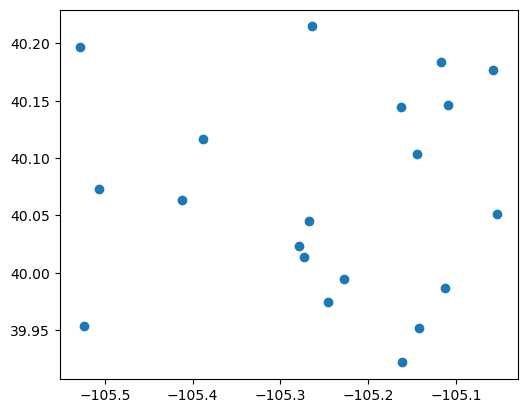

In [23]:
ss2024.plot()

<Axes: >

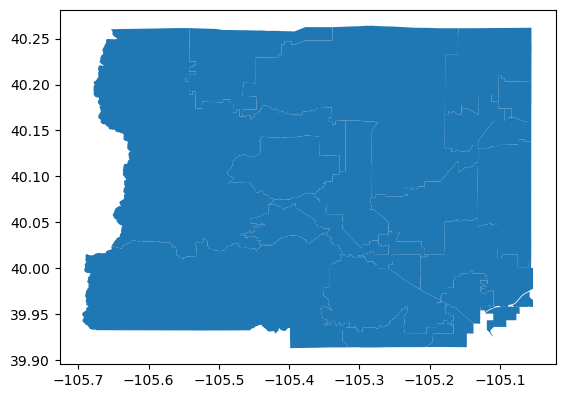

In [24]:
ss2024.set_geometry('border_geom').plot()

In [26]:

ss2024.to_excel('data/supersites_geom_2024.xlsx')

In [27]:


ss2024.drop(columns=['border_geom']).to_file('data/supersites_geom_2024.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   supersite        20 non-null     object  
 1   Venue            20 non-null     object  
 2   address          19 non-null     object  
 3   organization     18 non-null     object  
 4   website          19 non-null     object  
 5   google_map_link  19 non-null     object  
 6   google_map_name  20 non-null     object  
 7   lat              20 non-null     float64 
 8   lon              20 non-null     float64 
 9   google_map_url   19 non-null     object  
 10  website_url      19 non-null     object  
 11  geometry         20 non-null     geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 2.0+ KB


<Axes: >

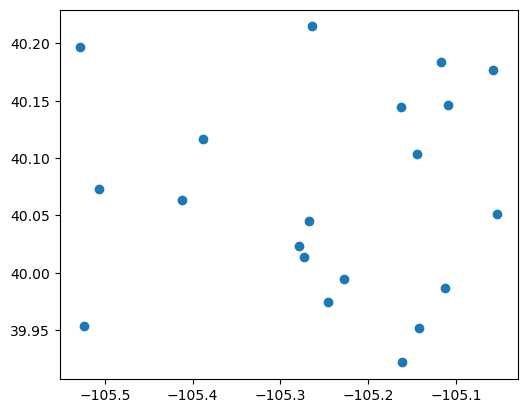

In [29]:
ss2024gdf = gpd.read_file('data/supersites_geom_2024.geojson', driver='GeoJSON')

ss2024gdf.info()
ss2024gdf.plot()
